# Mapping surface height dynamics to flow physics in free-surface turbulent flow - Code tutorial

# Loading packages

In [1]:
import numpy as np
import processdata3 as processdata         #this file contains all function for the processing, including how to run SHRED, calculate error metrics
import plot_results3 as plot_results     #file with plotting functions
import utilities3 as utilities       #file with different utility functions
import models           #file includes the SHRED model


# Data compression

As highlighted in the paper, in particular Section III A, we use the Singular Value Decomposition (SVD) to decompose the surface and velocity fields and work in the compressed space in the reconstruction. 


In the following cell, we calculate the SVD modes and store the **U**, **S** and **V** matrices in files. 

In [ ]:
#calculate and save SVD matrices


#TODO: fix file name/address dependency in code
#PROBLEM: cannot really load full velocity field to github

utilities.save_svd_full(eta_fluc, u_fluc, ens, case, variable, forecast=False, DNS=False, DNS_plane=None, DNS_surf=False, DNS_case='RE2500', new_teetank=False,)

#save all singular values for usage
utilities.save_singular_values_full(DNS_case, DNS_plane)

### Compressing DNS Case S2


In the following cell, we execute the function for calculating certain SVD modes, the singular value profile and turbulent spectra for different ranks, to reproduce Figs. 3 and 4 in the paper. 

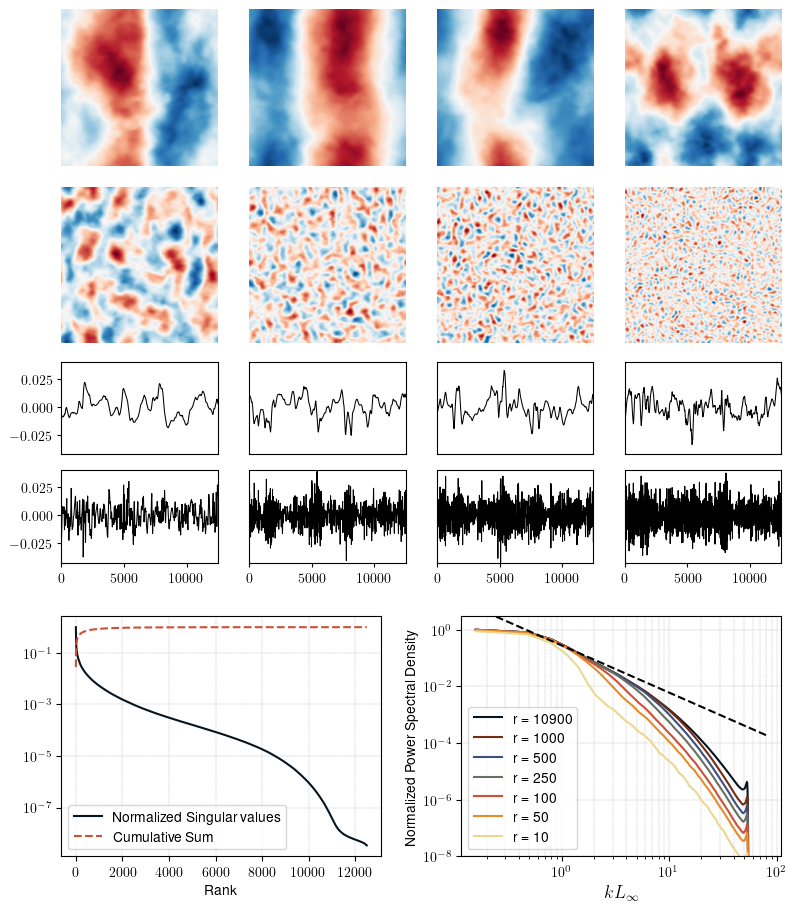

In [3]:
case='S2'                       
plane=1                                 #horizontal plane of choice -- for case S1: planes between [1, 57], for S2: [1,76]
rank_list=[10900,1000,500,250,100,50,10] #list of ranks for the spectral plot
labels=rank_list                        #make string labels for the ranks for the spectral plot
mode_list = [0,1,2,9,49,249,499,999]    #list of rank modes for the plots of U and V modes


plot_results.plot_svd_and_spectra_DNS(case,plane, rank_list, mode_list, labels)

### Compressing Experimental Case E2

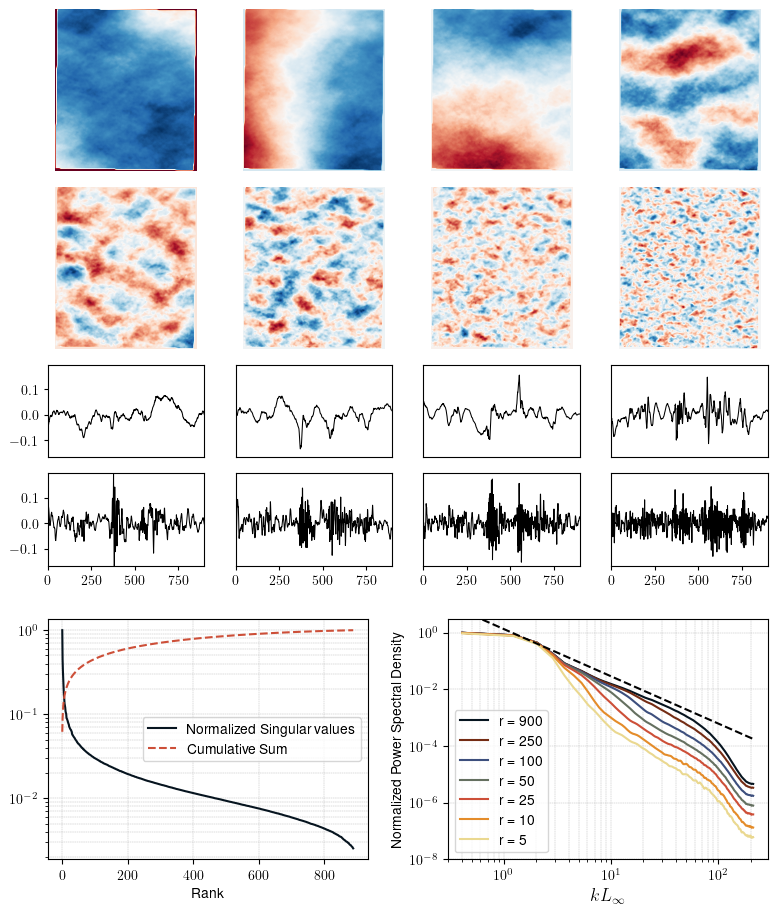

In [2]:
case='E2'
plane=3
rank_list = [900,250,100,50,25,10,5]
labels=rank_list
mode_list=[0,1,2,9,24,49,99,249]
ensembles=[5]

plot_results.plot_svd_and_spectra_exp(case,plane, rank_list, mode_list, labels, ensembles)

## **Run SHRED**

When executing SHRED, we decide how many planes to feed in, what case to run for, what rank compression we apply to the input, how many sensor to use and how many SHRED ensemble runs we want. 

### SHRED DNS CASE S2

Here we run SHRED for only two planes (plane 10, roughly $0.2 L_{\infty}$ deep, and plane 70 roughly $1.8 L_{\infty} deep$). We run only one ensemble for this test case

(65536, 12500)
rank:  250 
 SHRED ensemble:  100
sensor_loc:  [40800 49670 46552]
test:  [   10    24    27 ... 12436 12440 12443]
Training epoch 1
Error tensor(0.2637, device='cuda:0')
Training epoch 20
Error tensor(0.2592, device='cuda:0')
Training epoch 40
Error tensor(0.2390, device='cuda:0')
Training epoch 60
Error tensor(0.2059, device='cuda:0')
Training epoch 80
Error tensor(0.1784, device='cuda:0')
Training epoch 100
Error tensor(0.1627, device='cuda:0')
Training epoch 120
Error tensor(0.1558, device='cuda:0')
Training epoch 140
Error tensor(0.1486, device='cuda:0')
Training epoch 160
Error tensor(0.1443, device='cuda:0')
Training epoch 180
Error tensor(0.1429, device='cuda:0')
Training epoch 200
Error tensor(0.1418, device='cuda:0')
Training epoch 220
Error tensor(0.1400, device='cuda:0')
Training epoch 240
Error tensor(0.1397, device='cuda:0')
Training epoch 260
Error tensor(0.1391, device='cuda:0')
Training epoch 280
Error tensor(0.1398, device='cuda:0')
Training epoch 300
E

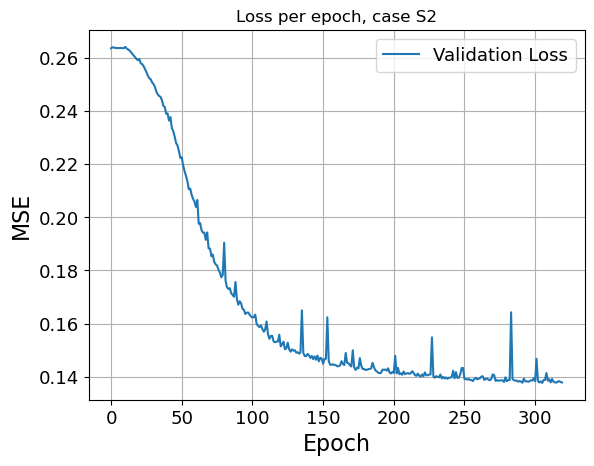

test error:  0.5383514


In [2]:
'''INPUT PARAMETERS'''
case='S2' 

full_planes=True                    #if all planes included, set this to True. 
vel_planes_selective = [10,70]      #else, we choose specific planes

num_sensors = 3   #number of sensors for surface measurement. Standard is 3.
ens_start=100 #start index for first SHRED ensemble (can be 0)
ens_end=100  #last index for SHRED ensemble
lags=52     #lags for the LSTM, standard is 52      
random_sampling=True    #if True, snapshots are randomly exctracted and separated to training, validation or testing 
                        #throughout the dataset. If False, a forecast is done (not fully functional as of now)


if case=='S1':
    vel_planes_all = np.arange(1,58)    #all planes for case S1
    r_vals = [225]                      #chosen rank for case S1
elif case=='S2':
    vel_planes_all = np.arange(1,77)    #all planes for case S2
    r_vals = [250]                      # chosen rank for case S2

if full_planes:
    vel_planes = vel_planes_all
else:
    vel_planes = vel_planes_selective


'''RUN ENSEMBLE OF SHRED'''
processdata.SHRED_ensemble_DNS(r_vals, num_sensors, ens_start, ens_end, vel_planes, 
                               lags, full_planes, random_sampling, case)

### SHRED Experimental case E2

In [ ]:
'''INPUT PARAMETERS'''

case = 'E2'

vel_plane = [2,5]
experimental_ens_list = [13]    #list of experimental ensembles to run for;
                                #NOTE: can be any from 1 to 20, except 4-10
r_vals = [100]    #chosen rank for cases E1 & E2 
num_sensors = 3 #number of sensors for surface measurement. Standard is 3.
ens_start=100   #start index for first SHRED ensemble (can be 0)
ens_end=100     #last index for SHRED ensemble
lags=52     #lags for the LSTM, standard is 52  
random_sampling=True    #if True, snapshots are randomly exctracted and separated to training, validation or testing 
                        #throughout the dataset. If False, a forecast is done (not fully functional as of now)


'''RUN ENSEMBLE OF SHRED'''
for k in range(len(vel_planes)):
    plane=vel_planes[k]
    planes = ['H395','H390', 'H375', 'H350', 'H300']
    exp_plane= planes[plane -1]
    
    for i in range(len(experimental_ens)):
        
        experimental_ens=experimental_ens[i]
        if experimental_ens > 10 or experimental_ens < 4:
            surf = utilities.get_normalized_surface_exp(case, plane, experimental_ens)

            processdata.SHRED_ensemble_exp(r_vals, num_sensors, surf, ens_start, ens_end, case, experimental_ens, lags, exp_plane=exp_plane, random_sampling=random_sampling)